<a href="https://colab.research.google.com/github/vearcon/TDP-espacios-publicos-origenes/blob/main/AnalisisPropiedades_FullRemoto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Instalo unas dependecias para que funque geopandas
!apt install libspatialindex-dev
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
#Borro una carpeta de ejemplos que carga alguna de esas dependecias
!rm -r sample_data
#Cargo el repositorio para poder acceder a todos los archivos directamente
!git clone https://github.com/vearcon/TDP-espacios-publicos-origenes

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libspatialindex-dev
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 285 kB of archives.
After this operation, 2,201 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 285 kB in 2s (164 kB/s)
Selecting previously unselected package libspatialindex-dev:amd64.
(Reading database ... 155230 files and directories currently installed.)
Preparing to unpack .../libspatialindex-dev_1.8.5-5_amd64.deb ...
Unpacking libspatialindex-dev:amd64 (1.8.5-5) ...
Setting up libspatialindex-dev:amd64 (1.8.5-5) ...


In [2]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import geopandas as gpd
import seaborn as sbn
from scipy import stats


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
# Definimos los nombres de los archivos y levantamos los datasets

path = 'TDP-espacios-publicos-origenes/'

argenprop = 'data_argenprop.csv'
meli = 'data_meli.csv'
zonaprop = 'zonaprop_procesado.csv'
properati = 'properati.csv'
barrios = 'barrios'       #Directorio con los archivos que definen los poligonos de barrios

d_a = pd.read_csv(path + argenprop ).dropna( subset = ['precio'] )
d_z = pd.read_csv(path + zonaprop  ).dropna( subset = ['precio'] )
d_p = pd.read_csv(path + properati ).dropna( subset = ['precio'] )
d_m = pd.read_csv(path +   meli    ).dropna( subset = ['precio'] )

def fuente(d, fuente_d):
    if 'fuente' not in d.columns:
        d['fuente'] = fuente_d
    try:
        return d.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
    except:
        return d

def fecha(d, f_min = '2021-01-01'):
    d['fecha'] = pd.to_datetime(d['fecha'], utc = 'UTC')
    return d[d.fecha > pd.to_datetime(f_min, utc = 'UTC')]

d_a = fuente(d_a, 'argenprop')
d_z = fuente(d_z, 'zonaprop')
d_p = fuente(d_p, 'properati')
d_m = fuente(d_m, 'meli')

#d_a = fecha(d_a)
d_z = fecha(d_z)
d_p = fecha(d_p)
d_m = fecha(d_m)

# Columnas a Trabajar

columnas = ['lat',
            'lon',
            'precio',
            'sup_total',
            'expensas',
            'ambientes',
            'fuente',
            'precio_moneda'
            ]

d_a = d_a[columnas]
d_z = d_z[columnas]
d_p = d_p[columnas]
d_m = d_m[columnas]

d_a = d_a[(d_a.precio_moneda == '$') | (d_a.precio_moneda == 'ars')]
d_z = d_z[(d_z.precio_moneda == '$') | (d_z.precio_moneda == 'ars')]
d_p = d_p[(d_p.precio_moneda == '$') | (d_p.precio_moneda == 'ars')]
d_m = d_m[(d_m.precio_moneda == '$') | (d_m.precio_moneda == 'ars')]

d_a = d_a.dropna(subset = set(columnas) - {'expensas'}).fillna(0)
d_z = d_z.dropna(subset = set(columnas) - {'expensas'}).fillna(0)
d_p = d_p.dropna(subset = set(columnas) - {'expensas'}).fillna(0)
d_m = d_m.dropna(subset = set(columnas) - {'expensas'}).fillna(0)



In [4]:
# Hacemos una inspección de lo que tenemos

print(d_a.head())
print(d_z.head())
print(d_p.head())
print(d_m.head())

d = d_a.append(d_z).append(d_p).append(d_m)

        lat       lon    precio  ...  ambientes     fuente  precio_moneda
0 -34.61254 -58.37179   63000.0  ...        4.0  argenprop              $
1 -34.57395 -58.49036   27000.0  ...        2.0  argenprop              $
2 -34.59708 -58.44789   49000.0  ...        3.0  argenprop              $
4 -34.56208 -58.45668  290000.0  ...        4.0  argenprop              $
6 -34.62949 -58.45923   52500.0  ...        4.0  argenprop              $

[5 rows x 8 columns]
         lat        lon   precio  ...  ambientes    fuente  precio_moneda
0 -34.600160 -58.426841  45000.0  ...        3.0  zonaprop              $
1 -34.569441 -58.396796  74000.0  ...        2.0  zonaprop              $
2 -34.612144 -58.440445  65000.0  ...        3.0  zonaprop              $
3 -34.606090 -58.379343  30000.0  ...        2.0  zonaprop              $
4 -34.584791 -58.424198  33000.0  ...        1.0  zonaprop              $

[5 rows x 8 columns]
            lat        lon    precio  ...  ambientes     fuente  pre

In [5]:
# El data set unificado
d = gpd.GeoDataFrame(d,
                     geometry = gpd.points_from_xy(y = d['lat'],
                                                   x = d['lon']
                                                  ),
                     crs = "EPSG:4326"
                    )
# Los polígonos de barrios
barrios = 'barrios'
d_barrios = gpd.read_file( barrios )
d_barrios = d_barrios.to_crs("EPSG:4326")

# Filtramos con los que están en CABA
d = gpd.sjoin(d, d_barrios[['BARRIO', 'geometry']])

#Guardamos dataset crudo unificado
#d.to_csv('data_geounificada_raw.csv')

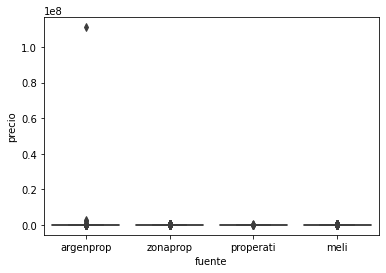

In [6]:
sbn.boxplot(data = d, y = 'precio', x = 'fuente')

In [ ]:
# Filtro en precio, sacando outliers
d = d[(d.precio < d.precio.quantile(0.99)) & (d.precio > d.precio.quantile(0.01))]
d = d[(d.sup_total < d.sup_total.quantile(0.99)) & (d.sup_total > d.sup_total.quantile(0.01))]

<AxesSubplot:xlabel='ambientes'>

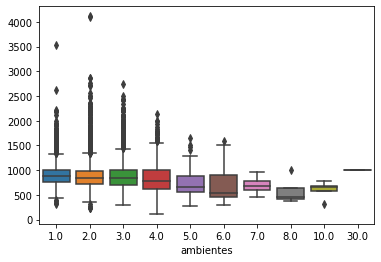

In [ ]:
sbn.boxplot(data = d, y = d['precio'] / d['sup_total'], x = 'ambientes')

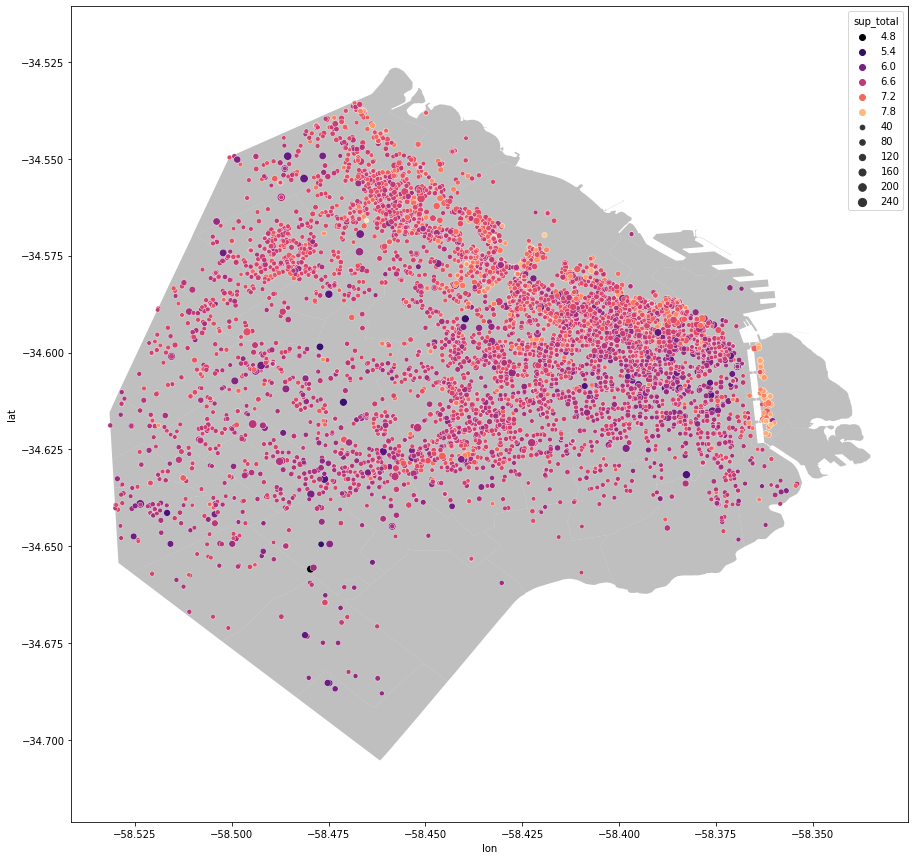

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))

d_barrios.plot(ax = ax, color = 'grey', alpha = 0.5)

sbn.scatterplot(data = d, y = 'lat', x = 'lon', hue = np.log(d['precio'] / d['sup_total']), size = d['sup_total'], ax = ax, palette = 'magma')

ax.axis('equal')

plt.show()